# Importing Libraries

In [1]:
import nbimporter
from Processing import red_tages_extracted

import numpy as np  
import pandas as pd  
from skimage import io, color, measure, img_as_ubyte, morphology  
from skimage.io import imread  
from skimage.draw import polygon, line  
from skimage.measure import label, regionprops  
from skimage.morphology import square, closing, binary_dilation, opening, erosion, remove_small_objects, disk  
from skimage import exposure, filters 
from skimage.util import img_as_ubyte  
import cv2 
from ultralytics import YOLO  
import matplotlib.pyplot as plt  
from matplotlib import patches 
from PIL import Image  
import os  
from scipy.spatial.distance import euclidean, cdist  

#  spike sites extraction

In [2]:
def classification_sipke(image_path,results):
    original_image = imread(image_path)  # Read image using matplotlib
    names = results[0].names
    # Get all the bounding boxes detected by the YOLOv8 model
    boxes = results[0].boxes
    # Create a dictionary `x` to store the count of each class
    x = {}
    # Iterate over each detected box to count each class
    for box in boxes:
        # Get the class ID of the current box and convert it to an integer
        cls_id = int(box.cls.cpu().numpy()[0])
        
        # Get the class name corresponding to the class ID
        class_name = names.get(cls_id)
        
        if class_name:  # If the class name exists
            # Update the class count in the dictionary `x`
            # If the class name is already in `x`, increment the count by 1; otherwise, initialize it as 1
            x[class_name] = x.get(class_name, 0) + 1
    
    # Get the count of "scab" and "spike" classes, with a default value of 0
    Scab = x.get("scab", 0)  # Get the count of "scab" class
    Spike = x.get("spike", 0)  # Get the count of "spike" class
    
    # Calculate the total number of spikes (sum of "scab" and "spike")
    Spikes = Scab + Spike
     # Get bounding box coordinates and corresponding labels from the prediction results
    label_site = results[0].boxes.xyxy.tolist()  # Bounding box coordinates in xyxy format
    label = results[0].boxes.cls.tolist()  # List of labels
    labels = [int(i) for i in label]  # Convert labels to integer type
    # Pair coordinates with labels, creating a tuple list of coordinates and labels
    label_site_spike_sets = [(site, label) for site, label in zip(label_site, labels)]
    for result_index, result in enumerate(results):
        # Get mask data
        masks = result.masks.xy
        # Create an empty mask of the same size as the original image
        combined_mask = np.zeros_like(original_image)

        # Iterate over each polygon to create the mask
        for polygon_coords in masks:
            if len(polygon_coords) >= 3:  # Ensure the polygon has enough points
                rr, cc = polygon(polygon_coords[:, 1], polygon_coords[:, 0], shape=combined_mask.shape)
                combined_mask[rr, cc, :] = original_image[rr, cc, :]

        # Convert the combined mask to a boolean mask
        bool_mask = combined_mask[:, :, 0].astype(bool)
        # Apply the boolean mask to retain the image area corresponding to the mask
        image_spike_masks = original_image * bool_mask[:, :, np.newaxis]
    
    return Spikes, Scab,label_site_spike_sets,image_spike_masks

In [3]:
def Coordinate_filtering(label_site_spike_sets, bbox_red_sets, number):
    # Create an empty list to store the final paired coordinates
    paired_coordinates = []
    # Convert 'number' to an integer to avoid repeated conversion during subsequent calculations
    number = int(number)
    # Process each red bounding box in bbox_red_sets
    for red_bbox in bbox_red_sets:
        # Skip the current red bounding box if there are fewer than 'number' label boxes
        if len(label_site_spike_sets) < number:
            break
        # Calculate the center coordinates of the red bounding box
        red_center = [(red_bbox[0] + red_bbox[2]) / 2, (red_bbox[1] + red_bbox[3]) / 2]
        min_distances = []
        # Iterate over each label bounding box in label_site_spike_sets
        for label_bbox, label in label_site_spike_sets:
            # Calculate the center coordinates of the label bounding box
            label_center = [(label_bbox[0] + label_bbox[2]) / 2, (label_bbox[1] + label_bbox[3]) / 2]
            # Calculate the Euclidean distance between the center of the red box and the label box
            distance = euclidean(red_center, label_center)
            # Store the distance, label box, label center, and label in the min_distances list
            min_distances.append((distance, label_bbox, label_center, label))
        # Sort the distances in ascending order and get the closest 'number' label boxes
        min_distances.sort(key=lambda x: x[0])
        closest_bboxes = min_distances[:number]
        # Initialize an empty list to store the selected label boxes for the current red box
        selected_bboxes = []

        # Try to select the closest label boxes, excluding those already selected by other red boxes
        for _, label_bbox, _, label in closest_bboxes:
            # Check if the label box has not been paired already, if not, add it to the selected list
            if (label_bbox, label) not in [(bbox, lbl) for bbox, lbl in paired_coordinates]:
                selected_bboxes.append((label_bbox, label))
                paired_coordinates.append((label_bbox, label))  # Add the label box to the paired list
    # Return all paired coordinates
    return paired_coordinates


In [4]:
def disease_spikes_mask_WFD(image, results):
    # Initialize an empty list to store the extracted ROI (Region of Interest) images
    roi_image_masks_WFD = []
    
    # Get the bounding boxes and masks from YOLOv8 detections
    boxes = results[0].boxes  # Retrieve the bounding boxes (includes coordinates and class information)
    masks = results[0].masks  # Retrieve the masks (contains the target area)

    # Iterate over each detection result (bounding boxes and masks correspond to each other)
    for box, mask in zip(boxes, masks):
        cls_id = int(box.cls.cpu().numpy()[0])  # Get the class ID (convert to integer)
        
        if cls_id == 0:  # Only process detections of class 0 (assuming class 0 represents the green area)
            # Get the current box coordinates (four points: top-left and bottom-right)
            coords = box.xyxy[0].cpu().numpy().astype(int)  # Convert to integer coordinates
            x1, y1, x2, y2 = coords  # Extract the four coordinate values
            
            # Ensure coordinates are within the image boundaries to avoid out-of-bounds errors
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)
            
            # Crop the ROI (Region of Interest) from the image using the bounding box coordinates
            roi_image_box = image[y1:y2, x1:x2]
            
            # Convert the cropped ROI image to 8-bit unsigned integer type
            roi_image_box = img_as_ubyte(roi_image_box)
            
            # Convert the image to grayscale
            gray_image = color.rgb2gray(roi_image_box)
            
            # Apply binary thresholding to the grayscale image: black regions become 0, other regions become 1
            binary_image = gray_image > 0
            
            # Label the connected components (mark adjacent regions in the binary image)
            label_image = label(binary_image)
            regions = regionprops(label_image)
            
            # If there are connected regions, find the largest connected component
            if regions:
                largest_region = max(regions, key=lambda r: r.area)  # Get the largest connected region
                
                # Create a mask for the largest connected region (retain only this region)
                largest_region_mask = label_image == largest_region.label
                
                # Create an empty filtered image and fill it with the largest connected region
                filtered_image = np.zeros_like(roi_image_box)
                filtered_image[largest_region_mask] = roi_image_box[largest_region_mask]
                
                # Append the processed image (filtered or original) to the ROI images list
                roi_image_masks_WFD.append(filtered_image)
            else:
                # If no connected region is found, add the original ROI image to the result list
                roi_image_masks_WFD.append(roi_image_box)
    
    # Return all extracted ROI images (either processed or original)
    return roi_image_masks_WFD


In [5]:
def spike_mask_acquisition(paired_coordinates, image_spike_masks, image_path):
    image_scab = []  # List to store images of diseased spikes
    disease_spike = []  # List to store coordinates of diseased spike regions
    
    # If there are no paired coordinates, return a diseased spike proportion of 0
    if not paired_coordinates:
        Proportion_of_diseased_panicles_region = 0
    else:
        # Read the original image
        original_image = imread(image_path)
        
        # Iterate over all paired coordinates and their labels
        for bbox_pair, labels in paired_coordinates:
            # Get the coordinates and convert them to integers
            x1, y1, x2, y2 = map(int, map(float, bbox_pair[:4]))

            # Check the coordinates to avoid out-of-bounds errors
            y1 = max(0, y1)  # Ensure y1 is not less than 0
            y2 = min(original_image.shape[0], y2)  # Ensure y2 does not exceed image height
            x1 = max(0, x1)  # Ensure x1 is not less than 0
            x2 = min(original_image.shape[1], x2)  # Ensure x2 does not exceed image width

            # Get the corresponding ROI image from the spike mask
            roi_image_box = image_spike_masks[y1:y2, x1:x2]

            # Convert the ROI image to 8-bit unsigned integer type
            roi_image_box = img_as_ubyte(roi_image_box)

            # Convert the image to grayscale
            gray_image = color.rgb2gray(roi_image_box)

            # Create a binary image: black areas are 0, other areas are 1
            binary_image = gray_image > 0

            # Get connected components (regions)
            label_image = label(binary_image)
            regions = regionprops(label_image)

            # Find the largest connected region and create a mask for it
            if regions:
                largest_region = max(regions, key=lambda r: r.area)  # Find the largest connected region
                largest_region_mask = label_image == largest_region.label  # Create the mask

                # Apply the mask to the ROI image
                filtered_image = np.zeros_like(roi_image_box)
                filtered_image[largest_region_mask] = roi_image_box[largest_region_mask]

                # Add the processed image to the list
                image_scab.append(filtered_image)
            else:
                # If no connected regions are found, add the original ROI image
                image_scab.append(roi_image_box)

            # Process only the case where the label is 0
            if labels == 0:  # Assuming label 0 represents the diseased spike region
                disease_spike.append(bbox_pair)
        
    # Calculate the proportion of diseased spike regions
    Pct_of_diseased_spikes_region = len(disease_spike) / len(paired_coordinates)

    # Return the list of diseased spike images and the proportion of diseased spike regions
    return image_scab, Pct_of_diseased_spikes_region

In [6]:
def Calculate_the_percentage_of_area_ExG(image):
    # Convert the input image to grayscale
    gray_image = color.rgb2gray(image)

    # Create a binary image: areas greater than 0 in the grayscale image are True, others are False
    binary_image = gray_image > 0
    # binary_image = erosion(binary_image, disk(3))  # Optional: Apply erosion, commented out here

    height, width = binary_image.shape  # Get the image's height and width

    # Set the radius for the erosion operation, here using 5% of the image width as an example
    radius_percentage = 0.05  # 5%
    radius = int(min(height, width) * radius_percentage)  # Calculate the erosion radius

    # Perform erosion operation to shrink objects in the binary image
    binary_image = erosion(binary_image, disk(radius))

    # Step 1: Label the connected components in the binary image
    label_image = measure.label(binary_image)

    # Step 2: Calculate the properties (e.g., area, boundary) of each connected region
    props = measure.regionprops(label_image)

    # If no regions are found, return 0 and None
    if len(props) == 0:
        return 0, None, None

    # Find the largest connected component by area
    max_area_idx = np.argmax([prop.area for prop in props])
    
    # Get the mask of the largest region
    max_region_mask = label_image == props[max_area_idx].label
    binary_img = max_region_mask  # Save the binary image of the largest region

    # Use the mask to compute the ExG (Excess Green) index to highlight green regions
    masked_image = image.copy()  # Copy the original image
    masked_image[~binary_img] = 0  # Set non-masked areas to black (or another value)

    # Extract the RGB channels
    R = masked_image[:, :, 0].astype(float)
    G = masked_image[:, :, 1].astype(float)
    B = masked_image[:, :, 2].astype(float)

    # Calculate the ExG index: ExG = 2 * G - R - B
    ExG = 2 * G - R - B
    ExG_normalized = exposure.rescale_intensity(ExG, in_range=(-255, 255), out_range=(0, 1))  # Normalize ExG

    # Use Otsu's method to determine a fixed threshold for segmenting green regions
    fixed_threshold = filters.threshold_otsu(ExG_normalized)

    # Generate ExG binary image using a fixed threshold
    fixed_threshold = 0.6  # This can be adjusted based on actual conditions
    binary_mask = ExG_normalized > fixed_threshold

    # Create a binary mask based on both ExG and HSV criteria
    binary_exg = (ExG > fixed_threshold) & binary_mask

    min_size = int((width*height)* 0.01)  
    green_mask = remove_small_objects(binary_exg, min_size=min_size)

    # Create a mask for non-green areas
    non_green_mask = np.logical_not(green_mask)
    # Apply the non-green mask to the largest region mask
    non_green_final_mask = binary_img & non_green_mask
    non_green_final_mask = remove_small_objects(non_green_final_mask, min_size=min_size)  # Remove small regions
        # Step 3: Label the connected components in the non-green areas
    label_non_green = measure.label(non_green_final_mask)
    props_non_green = measure.regionprops(label_non_green)

    # If no non-green regions are found, return 0 and None
    if len(props_non_green) == 0:
        return 0, None, None

    # Find the largest non-green region
    max_area_idx_non_green = np.argmax([prop.area for prop in props_non_green])
    max_region_mask_non_green = label_non_green == props_non_green[max_area_idx_non_green].label

    # Calculate the area ratio
    spike_pixs = np.sum(binary_img)  # Calculate the number of pixels in the largest connected region (diseased spike area)
    scab_pixs = np.sum(max_region_mask_non_green)  # Calculate the number of pixels in the largest non-green area (scab area)
    green_pixs = np.sum(green_mask)  # Calculate the number of pixels in the green area
    scab_area_ratio = np.nan_to_num(scab_pixs / spike_pixs)  # Calculate the ratio of scab area to diseased spike area

    # Return the scab area ratio, the mask of the non-green region, and the binary image of the largest connected region
    return scab_area_ratio, max_region_mask_non_green, binary_img


In [7]:
def adjust_line_position(rr, cc, max_region_polygon_on_opened):
    # Check the proportion of the line that lies within the region of 1's.
    # If it's less than 80%, adjust the position of the line.
    if np.sum(max_region_polygon_on_opened[rr, cc] == 1) < len(rr) * 0.8:
        # Calculate the center position of the 1's region.
        center_y, center_x = np.mean(np.argwhere(max_region_polygon_on_opened == 1), axis=0)
        # Calculate the vertical and horizontal shifts needed to move the line towards the center.
        line_y_shift = np.mean(rr) - center_y
        line_x_shift = np.mean(cc) - center_x
        
        # Adjust the coordinates of the line.
        rr_adjusted = rr - int(line_y_shift)
        cc_adjusted = cc - int(line_x_shift)
        
        # Ensure that the coordinates are within the image bounds.
        rr_adjusted = np.clip(rr_adjusted, 0, max_region_polygon_on_opened.shape[0] - 1)
        cc_adjusted = np.clip(cc_adjusted, 0, max_region_polygon_on_opened.shape[1] - 1)
        
        return rr_adjusted, cc_adjusted
    else:
        # If the proportion is sufficient, return the original coordinates.
        return rr, cc


def Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened):
    # If either the binary image or the region is None, return a length ratio of 0.
    if max_region_polygon_on_opened is None or binary_img is None:
        return 0  

    # Label the connected components and calculate region properties.
    label_image = measure.label(binary_img)
    props = measure.regionprops(label_image)
    
    # Find the largest connected component based on its area.
    max_area_idx = np.argmax([prop.area for prop in props])
    coords = props[max_area_idx].coords

    # Get the boundary coordinates in different directions.
    top_coords = coords[0]
    bottom_coords = coords[-1]
    left_bottom_coords = min(coords, key=lambda x: x[0] + x[1])
    right_top_coords = max(coords, key=lambda x: x[0] + x[1])
    left_top_coords = min(coords, key=lambda x: x[0] - x[1])
    right_bottom_coords = max(coords, key=lambda x: x[0] - x[1])
    
    # Calculate the maximum distances in three different directions.
    distances = [
        np.linalg.norm(np.array(top_coords) - np.array(bottom_coords)),
        np.linalg.norm(np.array(left_bottom_coords) - np.array(right_top_coords)),
        np.linalg.norm(np.array(left_top_coords) - np.array(right_bottom_coords))
    ]
    
    # Identify the direction with the longest distance.
    max_distance_idx = np.argmax(distances)
    rr, cc = None, None
    
    # Based on the longest distance, connect the corresponding boundary coordinates.
    if max_distance_idx == 0:
        rr, cc = line(top_coords[0], top_coords[1], bottom_coords[0], bottom_coords[1])
    elif max_distance_idx == 1:
        rr, cc = line(left_bottom_coords[0], left_bottom_coords[1], right_top_coords[0], right_top_coords[1])
    else:
        rr, cc = line(left_top_coords[0], left_top_coords[1], right_bottom_coords[0], right_bottom_coords[1])
    
    # Adjust the line's position if necessary.
    rr_adjusted, cc_adjusted = adjust_line_position(rr, cc, max_region_polygon_on_opened)
    
    # Calculate the proportion of the line that lies within the region of 1's.
    total_line_length = len(rr)
    count_in_region = np.sum(max_region_polygon_on_opened[rr_adjusted, cc_adjusted] == 1)
    length_ratio = count_in_region / total_line_length if total_line_length != 0 else 0
    
    # Return the proportion of the line in the region of 1's.
    return length_ratio


In [8]:
def plt_diseased_spikes(diseased_spike_image_Yolov8):
    # Calculate the width of each image and sort them in descending order
    image_widths = [img.shape[1] for img in diseased_spike_image_Yolov8]  # Get the width of each image
    sorted_indices = np.argsort(image_widths)[::1]  # Get the indices that sort the widths in descending order

    # Rearrange the images based on the sorted indices
    sorted_images = [diseased_spike_image_Yolov8[i] for i in sorted_indices]

    # Calculate the required number of rows and columns for the plot
    num_rows = len(sorted_images) // 5 + (1 if len(sorted_images) % 5 != 0 else 0)  # Calculate the number of rows
    num_cols = min(len(sorted_images), 20)  # The number of columns is at most 10

    # Set the figure size for the plot
    plt.figure(figsize=(num_cols, num_rows))

    # Display each image in a subplot
    for i in range(len(sorted_images)):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(sorted_images[i])  # Display the image
        plt.axis('off')  # Hide the axes for a cleaner view

    # Show the plot with all images
    plt.show()

# With of red markers

In [9]:
def trait_output_red_markers(image_path,model):
    # 加载 YOLOv8-WFD 模型
    results = model.predict(image_path, conf=0.5, save=False, show=False, show_labels=False)
    # 执行 red_tages_extracted 函数（此处返回的 bbox_red_sets 就表示运行了 red_tages_extracted）
    bbox_red_sets, image_display = red_tages_extracted(image_path)
    # 执行其他检测函数
    Spikes, Scab, label_site_spike_sets, image_spike_masks = classification_sipke(image_path, results)
    SxSpkPct_Plot=Scab/len(bbox_red_sets)
    # 当 red_tages_extracted 函数运行时，调用 Coordinate_filtering 时使用 number=4
    paired_coordinates = Coordinate_filtering(label_site_spike_sets, bbox_red_sets, number=4)
    roi_image_masks_WFD = disease_spikes_mask_WFD(image_spike_masks, results)
    image_scab, SxSpkPct_ROI=spike_mask_acquisition(paired_coordinates, image_spike_masks, image_path)
    # Initialize lists for the area ratio and length ratio of diseased spike regions
    diseased_spike_image_Yolov8_Area_ratio, diseased_spike_image_Yolov8_Length_ratio = [], []
    # If diseased spike images exist
    if roi_image_masks_WFD:
        for i in roi_image_masks_WFD:
            # Calculate the area ratio and length ratio for each diseased spike region
            Area_ratio, max_region_polygon_on_opened, binary_img = Calculate_the_percentage_of_area_ExG(i)
            Length_ratio = Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened)

            # Append the calculated area ratio and length ratio to the respective lists
            diseased_spike_image_Yolov8_Area_ratio.append(Area_ratio)
            diseased_spike_image_Yolov8_Length_ratio.append(Length_ratio)
        AvgSxArea_Spk = np.mean(diseased_spike_image_Yolov8_Area_ratio) 
        AvgSxLen_Spk = np.mean(diseased_spike_image_Yolov8_Length_ratio) 


    T_Area_ratio, T_Length_ratio = [], []
    # Process all diseased spike images in the new set
    for i in image_scab:
        # Calculate the area ratio and length ratio for each diseased spike region
        Area_ratio, max_region_polygon_on_opened, binary_img = Calculate_the_percentage_of_area_ExG(i)
        Length_ratio = Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened)

        # Append the calculated area ratio and length ratio to the respective lists
        T_Area_ratio.append(Area_ratio)
        T_Length_ratio.append(Length_ratio)

    # Calculate the cumulative area and length ratios for the new diseased spike regions
    CumSxArea_ROI = np.sum(T_Area_ratio) 
    CumSxLen_ROI = np.sum(T_Length_ratio)   
    
    return SxSpkPct_Plot,SxSpkPct_ROI, CumSxArea_ROI, AvgSxArea_Spk, CumSxLen_ROI, AvgSxLen_Spk,image_scab,results



image 1/1 C:\Users\liush\Desktop\Evaluation plantform-wheat FHB\Data\2.jpg: 640x352 5 scabs, 65 spikes, 153.7ms
Speed: 5.0ms preprocess, 153.7ms inference, 31.8ms postprocess per image at shape (1, 3, 640, 352)


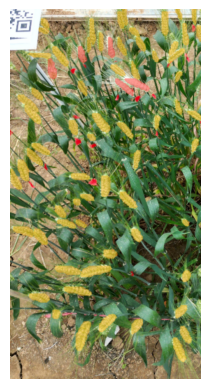

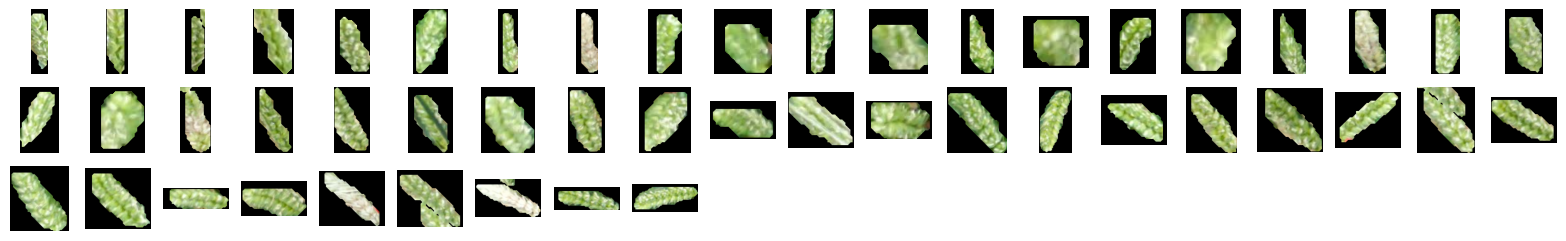

In [13]:
model = YOLO("Model_save/Yolov8-WFD.pt") 
image_path="Data/2.jpg"
_,_, _, _, _, _,image_scab,results=trait_output_red_markers(image_path,model)
for r in results:
    im_array = r.plot(conf=0.5, labels=False, boxes=False)  # Plot the prediction
    predict_image = Image.fromarray(im_array[..., ::-1])  # Convert to image
    plt.axis("off")
    plt.imshow(predict_image)
# Display the detected diseased spike regions in a grid
plt_diseased_spikes(image_scab)

#  Without of red markers

In [14]:
def trait_output_without_red_markers(image_path,model):
    # 加载 YOLOv8-WFD 模型
    results = model.predict(image_path, conf=0.5, save=False, show=False, show_labels=False)
    Spikes, Scab, label_site_spike_sets, image_spike_masks = classification_sipke(image_path, results)
    SxSpkratio_Plot=Scab/Spikes
    roi_image_masks_WFD = disease_spikes_mask_WFD(image_spike_masks, results)
    # Initialize lists for the area ratio and length ratio of diseased spike regions
    diseased_spike_image_Yolov8_Area_ratio, diseased_spike_image_Yolov8_Length_ratio = [], []
    # If diseased spike images exist
    if roi_image_masks_WFD:
        for i in roi_image_masks_WFD:
            # Calculate the area ratio and length ratio for each diseased spike region
            Area_ratio, max_region_polygon_on_opened, binary_img = Calculate_the_percentage_of_area_ExG(i)
            Length_ratio = Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened)

            # Append the calculated area ratio and length ratio to the respective lists
            diseased_spike_image_Yolov8_Area_ratio.append(Area_ratio)
            diseased_spike_image_Yolov8_Length_ratio.append(Length_ratio)
        AvgSxArea_Spk = np.mean(diseased_spike_image_Yolov8_Area_ratio) 
        AvgSxLen_Spk = np.mean(diseased_spike_image_Yolov8_Length_ratio) 
        # Calculate the cumulative area and length ratios for the new diseased spike regions
        CumSxArea_ROI = np.sum(diseased_spike_image_Yolov8_Area_ratio) 
        CumSxLen_ROI = np.sum(diseased_spike_image_Yolov8_Length_ratio)   

    return SxSpkratio_Plot, CumSxArea_ROI, AvgSxArea_Spk, CumSxLen_ROI, AvgSxLen_Spk,roi_image_masks_WFD,results


image 1/1 C:\Users\liush\Desktop\Evaluation plantform-wheat FHB\Data\2.jpg: 640x352 5 scabs, 65 spikes, 39.3ms
Speed: 4.0ms preprocess, 39.3ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 352)


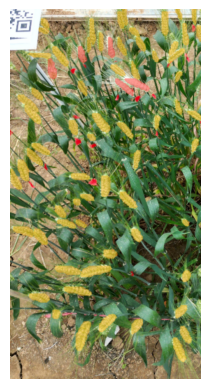

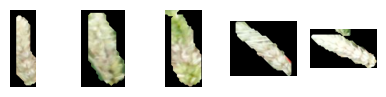

In [15]:
model = YOLO("Model_save/Yolov8-WFD.pt") 
image_path="Data/2.jpg"
_, _, _, _, _,roi_image_masks_WFD,results=trait_output_without_red_markers(image_path,model)
for r in results:
    im_array = r.plot(conf=0.5, labels=False, boxes=False)  # Plot the prediction
    predict_image = Image.fromarray(im_array[..., ::-1])  # Convert to image
    plt.axis("off")
    plt.imshow(predict_image)
# Display the detected diseased spike regions in a grid
plt_diseased_spikes(roi_image_masks_WFD)
